# Brain Tumor Detection Using Convolutional Neural Network

## Import Necessary Modules

In [6]:
!pip install tensorflow

In [8]:
!pip install opencv-python

In [10]:
!pip install imutils

In [112]:
%matplotlib inline

#Built-in
import os
import random

# Data science + preprocessing
import shutil
import time
import numpy as np
import cv2
import imutils
from PIL import Image
import zipfile

# Visualization
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import shuffle

## Setup and Download Dataset

**About the Brain Tumor MRI dataset:**

The dataset contains two folders: Training, which includes 5,712 images, and Testing, which includes 1,311 images. You can find it [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data).

In [15]:
!pip install kaggle

In [17]:
# Create a custom config directory to store kaggle.json securely
custom_config_dir = os.path.join(os.getcwd(), "kaggle_config")
os.makedirs(custom_config_dir, exist_ok=True)

# Copy the kaggle.json file
shutil.copy("kaggle.json", os.path.join(custom_config_dir, "kaggle.json"))

# Lock permissions for security 
!chmod 600 kaggle_config/kaggle.json

# Set environment variable
os.environ['KAGGLE_CONFIG_DIR'] = custom_config_dir

# Download dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

#Unzip data
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_mri_dataset")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


## Preprocessing
Resize images to a fixed shape, normalize pixel values, and assign labels.

In [20]:
def preprocess_images(dataset_dir, target_size=(240, 240)):
    images = []
    labels = []

    for label_name in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_name)
        if os.path.isdir(label_path):
            # Assign labels: 0 for 'notumor', 1 for anything else
            label = 0 if label_name.lower() == "notumor" else 1

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [22]:
# Run the preprocessing function
image_dir = "brain_tumor_mri_dataset/Training"
X, y = preprocess_images(image_dir)

print(f"Total images: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")
print(f"Labels: {np.unique(y, return_counts=True)}")

Total images: 5712
Image shape: (240, 240, 3)
Labels: (array([0, 1]), array([1595, 4117]))


In [24]:
test_dir = "brain_tumor_mri_dataset/Testing"
X_test, y_test = preprocess_images(test_dir)

print(f"Total images: {X_test.shape[0]}")
print(f"Image shape: {X_test.shape[1:]}")
print(f"Labels: {np.unique(y_test, return_counts=True)}")

Total images: 1311
Image shape: (240, 240, 3)
Labels: (array([0, 1]), array([405, 906]))


**Visualize Sample Images with Labels**

In [27]:
def plot_sample_images(X, y, n=50):
    for label in [0, 1]:
        images = X[y == label][:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        fig = plt.figure(figsize=(15, 3.5))
        fig.subplots_adjust(hspace=0, wspace=0.2) 

        for i, image in enumerate(images):
            ax = plt.subplot(rows_n, columns_n, i + 1)
            ax.imshow(image)
            ax.axis('off')

        label_str = "Tumor" if label == 1 else "No Tumor"
        plt.suptitle(f"Brain Tumor: {label_str}", fontsize=20)
        plt.show()

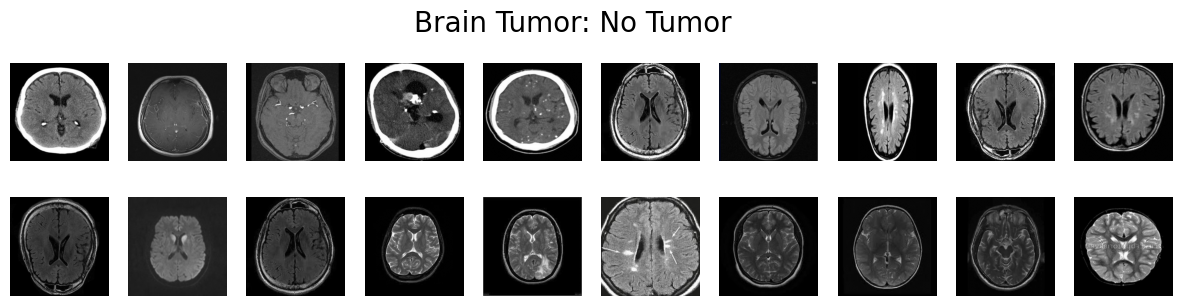

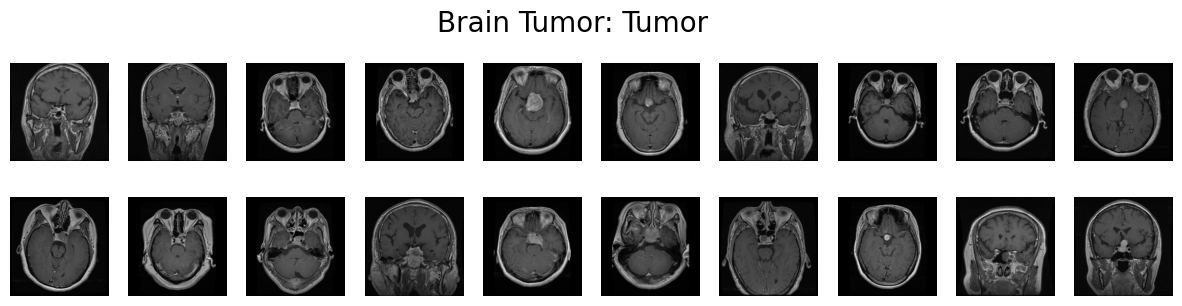

In [29]:
plot_sample_images(X_test, y_test, n=20)

## Split the data

Split X and y into training, validation (development) and validation sets. 

In [32]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training, validation, and test sets.
    Arguments:
        X: Image data, shape = (N, W, H, C)
        y: Labels, shape = (N,)
        test_size: % to reserve for validation + test (default 20%)
        random_state: Reproducibility seed
    Returns:
        X_train, y_train: 60%
        X_val, y_val: 20%
        X_test, y_test: 20%
    """
    # First split: 80% train, 20% test_val
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Second split: Half of test_val goes to val, half to test
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=random_state
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:
1. 70% of the data for training
2. 15% of the data for validation
3. 15% of the data for testing

In [35]:
X_full, y_full = preprocess_images("brain_tumor_mri_dataset/Training")

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_full, y_full)

In [40]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))
print("All shapes printed above")

number of training examples = 4569
number of development examples = 571
number of test examples = 572
X_train shape: (4569, 240, 240, 3)
Y_train shape: (4569,)
X_val (dev) shape: (571, 240, 240, 3)
Y_val (dev) shape: (571,)
X_test shape: (572, 240, 240, 3)
Y_test shape: (572,)
All shapes printed above


Some helper function:

In [42]:
# Nicely formatted time string as hours:minutes:seconds
def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}:{m:02}:{s:02}"

In [44]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:


In [47]:
def build_model(input_shape=(240, 240, 3)):
    inputs = Input(shape=input_shape)

    # ZeroPadding2D
    x = ZeroPadding2D(padding=(2, 2))(inputs)  # Output: (244, 244, 3)

    # Conv2D -> BatchNorm -> ReLU
    x = Conv2D(32, (7, 7), strides=1)(x)       # Output: (238, 238, 32)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # MaxPool 1
    x = MaxPooling2D(pool_size=(4, 4))(x)      # Output: (59, 59, 32)

    # MaxPool 2
    x = MaxPooling2D(pool_size=(4, 4))(x)      # Output: (14, 14, 32)

    # Flatten & Fully Connected Layer
    x = Flatten()(x)                           # Output: (1, 6272)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [49]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model

In [52]:
# Model Compilation to prepares the model for training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Set up logging for TensorBoard to visualize training/validation loss and accuracy in real-time
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [56]:
# Save the model that performs best on validation accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.keras".format(filepath), 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

In [71]:
# This will stop training when validation accuracy stop improving (for 3 consecutive epochs)
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

## Train the model

In [74]:
print(f"Train on {X_train.shape[0]} samples, validate on {X_val.shape[0]} samples")

start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint, early_stop],
    epochs=30,
    batch_size=32
)
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 4569 samples, validate on 571 samples
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 705ms/step - accuracy: 0.9836 - loss: 0.0408 - val_accuracy: 0.9667 - val_loss: 0.1459
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.9919 - loss: 0.0238 - val_accuracy: 0.9702 - val_loss: 0.1040
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 701ms/step - accuracy: 0.9933 - loss: 0.0260 - val_accuracy: 0.9720 - val_loss: 0.1044
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 706ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9720 - val_loss: 0.1082
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 703ms/step - accuracy: 0.9911 - loss: 0.0247 - val_accuracy: 0.9667 - val_loss: 0.1448
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 700ms/step - accuracy: 0.9918 - loss: 0.0259 - val_accuracy: 0.8967 - val_loss: 0.3205
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 702ms/step - accuracy: 0.9870 - loss: 0.0355 - val_accuracy: 0.9737 - val_loss: 0.1166
Epoch 8/30
143/143 ━━━━━━━━━━

## When will training stop?

We are using EarlyStopping to prevent overfitting and save time during training.

1. Monitor: val_loss (validation loss)
2. Patience: 10

This means the training will stop early if the validation loss does not improve after 10 consecutive epochs.

In [77]:
history = model.history.history

In [79]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Training vs. Validation Accuracy & Loss

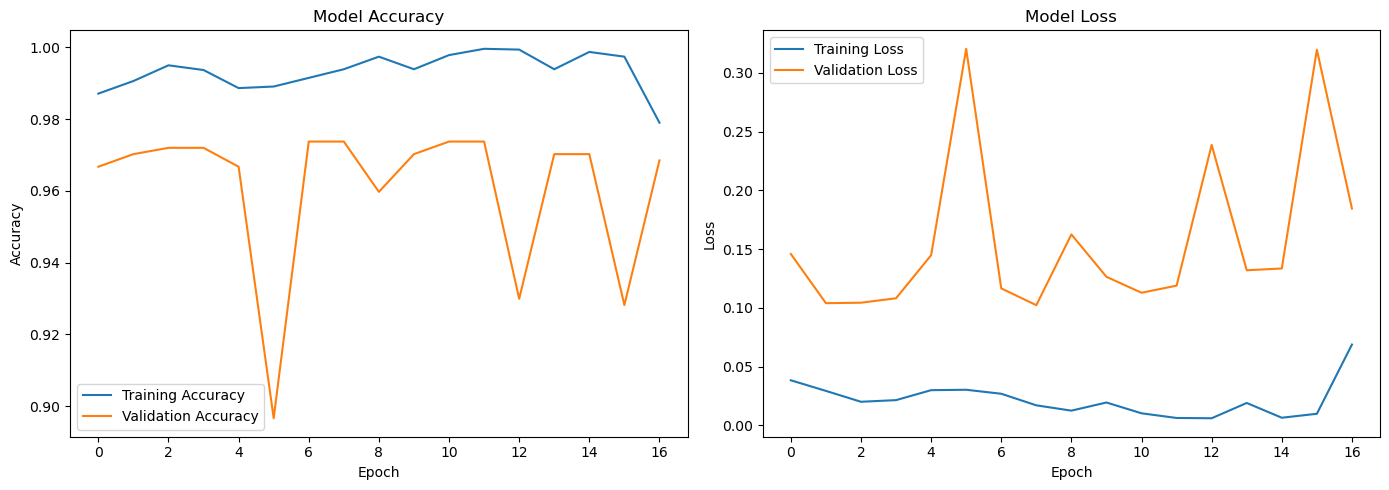

In [82]:
# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Interpreting Training/Validation Accuracy and Loss 

From the plots above:

- Training Accuracy and Loss show that the model is learning the training data very well — accuracy reaches nearly 100% and loss is extremely low.

- However, Validation Accuracy fluctuates and Validation Loss shows significant spikes at certain epochs (e.g., around epochs 5 and 15), indicating that the model's performance on unseen data is less stable.

These signs point to overfitting, where the model is too tailored to the training set and struggles to generalize to the validation set.

To address this, I included EarlyStopping with patience=10 to halt training when validation performance stops improving. 

### Further Steps to Improve the Model
To address overfitting and improve validation performance, we could consider to use the following strategies:
- Applying data augmentation: Random transformations on images to simulate more training data.

- Adding regularization: Techniques like Dropout layers or L2 regularization to prevent overfitting.

- Simplifying the model: Reducing model complexity (e.g., fewer layers or filters).

- Collecting more training data: More diverse and balanced data often leads to better generalization.

This helps ensure the model doesn’t just memorize the training data, but actually learns meaningful patterns that generalize well to new, unseen examples.

# Results

This section presents the final model performance and prediction results on unseen test data.

### Load the best model

In [95]:
for file in os.listdir("models"):
    if file.endswith(".keras"):
        print(file)

cnn-parameters-improvement-04-0.92.keras
cnn-parameters-improvement-03-0.91.keras
cnn-parameters-improvement-01-0.74.keras
cnn-parameters-improvement-02-0.87.keras
cnn-parameters-improvement-06-0.96.keras
cnn-parameters-improvement-09-0.97.keras
cnn-parameters-improvement-05-0.96.keras
cnn-parameters-improvement-07-0.97.keras
cnn-parameters-improvement-08-0.96.keras


In [97]:
best_model = load_model("models/cnn-parameters-improvement-09-0.97.keras")

### Evaluate the Model on the Test Set:

In [100]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9838 - loss: 0.0711
Test Accuracy: 0.9773
Test Loss: 0.0847


### F1 score for the best model on the testing data:

F1 score helps us measure how well the model balances between detecting tumors and avoiding false alarms — making it a more reliable metric for medical classification problems than accuracy alone.

In [114]:
# Get predictions from the model
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Print F1 Score and other metrics
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
F1 Score: 0.9842041312272175

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       160
           1       0.99      0.98      0.98       412

    accuracy                           0.98       572
   macro avg       0.97      0.97      0.97       572
weighted avg       0.98      0.98      0.98       572



### Predict and Visualize Some Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


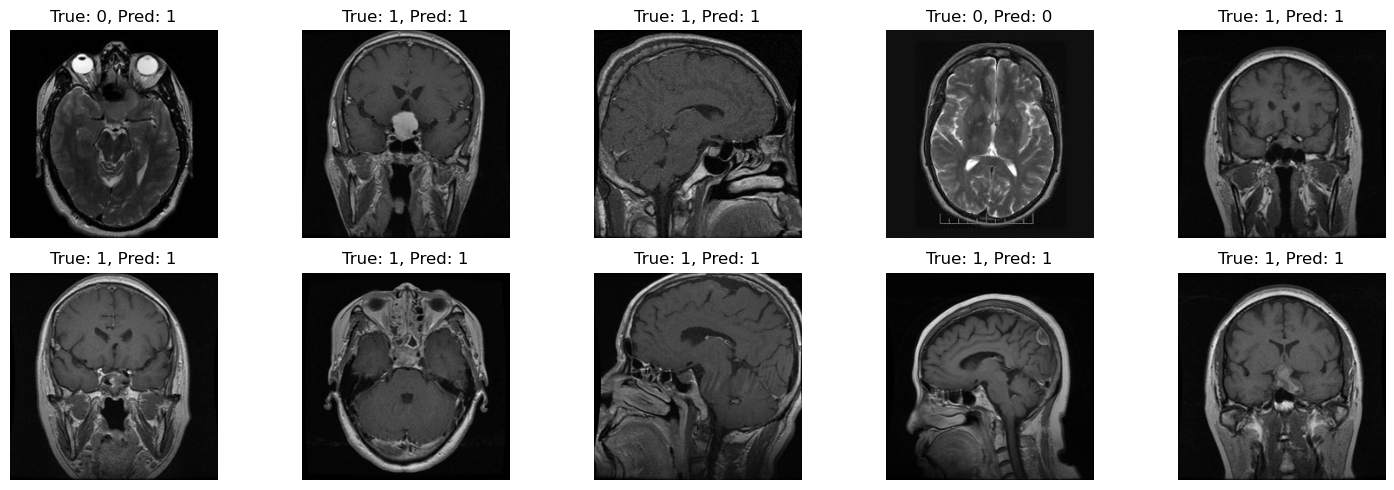

In [108]:
# Randomly select some test indices
indices = random.sample(range(len(X_test)), 10)
sample_images = X_test[indices]
sample_labels = y_test[indices]
predictions = best_model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

# Plot the predictions

plt.figure(figsize=(15, 5))
for i, (img, true, pred) in enumerate(zip(sample_images, sample_labels, predicted_labels)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true}, Pred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Results Interpretation

def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [120]:
# the whole data
data_percentage(y)

Number of examples: 5712
Percentage of positive examples: 72.07633053221288%, number of pos examples: 4117
Percentage of negative examples: 27.923669467787114%, number of neg examples: 1595


In [122]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 4569
Percentage of positive examples: 72.07266360253885%, number of pos examples: 3293
Percentage of negative examples: 27.92733639746115%, number of neg examples: 1276
Validation Data:
Number of examples: 571
Percentage of positive examples: 72.15411558669001%, number of pos examples: 412
Percentage of negative examples: 27.84588441330998%, number of neg examples: 159
Testing Data:
Number of examples: 572
Percentage of positive examples: 72.02797202797203%, number of pos examples: 412
Percentage of negative examples: 27.972027972027973%, number of neg examples: 160


In [124]:
best_model.save("brain_tumor_cnn_model.keras")

# Conclusion

In this project, I developed a Convolutional Neural Network (CNN) to classify brain MRI images as tumorous (1) or non-tumorous (0). After training the model and tuning it with early stopping and model checkpointing, I evaluated the best model on a separate test set.

### Final Model Performance:

- **Test Accuracy:** 98%

- **F1 Score:** 0.98

- **Precision / Recall (Class 1 – Tumor):** 0.99 / 0.98

- **Precision / Recall (Class 0 – No Tumor):** 0.96 / 0.96

These results demonstrate that the model performs exceptionally well, especially in identifying tumorous cases — which is critical in a real-world medical application.

## Acknowledgments

This project was inspired by and adapted from:

- 🧠 [Brain Tumor Detection by Mohamed Ali Habib](https://github.com/MohamedAliHabib/Brain-Tumor-Detection/blob/master/Brain%20Tumor%20Detection.ipynb)  
  Portions of the code for CNN architecture, and training workflow were referenced and modified from this notebook.

- 📊 Dataset: [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)  
  Provided by Masoud Nickparvar on Kaggle. The dataset includes MRI scans categorized into glioma, meningioma, pituitary tumor, and no tumor.